# Assembling a GSFLOW model from PRMS and MODFLOW

When developing integrated hydrologic models, it's often the case that the watershed model and groundwater model are developed independently and then connected. This notebook demonstrates how to link the surface water and groundwater models to create a GSFLOW model. Furthermore, this notebook demonstrates some basic model visualization techniques.

<img src = "./figures/WorkFlow.PNG">


In [1]:
import os
from gsflow import GsflowModel
import flopy
import matplotlib.pyplot as plt
import pandas
import numpy as np
import platform

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

print(flopy.__version__)

3.3.5


### Load the PRMS model using pyGSFLOW

Loading the PRMS model is accomplished using `GsflowModel.load_from_file()` function call. Because the control file specifies "PRMS" mode and does not include information about MODFLOW, only PRMS input files are loaded.

In [2]:
control_file = os.path.join(".", "data", "sagehen", "prms", "windows", "sagehen.control")
gsf = GsflowModel.load_from_file(control_file);

Control file is loaded
Working on loading PRMS model ...
Prms model loading ...
------------------------------------
Reading parameter file : C:\Users\jlarsen\Desktop\usgs-pygsflow\usgs.gov.releases\pygsflow\examples\data\sagehen\prms\input\calibration_parameters.param
------------------------------------
------------------------------------
Reading parameter file : C:\Users\jlarsen\Desktop\usgs-pygsflow\usgs.gov.releases\pygsflow\examples\data\sagehen\prms\input\cascade.param
------------------------------------
------------------------------------
Reading parameter file : C:\Users\jlarsen\Desktop\usgs-pygsflow\usgs.gov.releases\pygsflow\examples\data\sagehen\prms\input\default_values.param
------------------------------------
------------------------------------
Reading parameter file : C:\Users\jlarsen\Desktop\usgs-pygsflow\usgs.gov.releases\pygsflow\examples\data\sagehen\prms\input\gis_derived_parameters.param
------------------------------------
PRMS model loaded ...


### Load Modflow using pygsflow

pyGSFLOW has a module that loads Modflow input files. This module calls a number of FloPy classes and routines, but corrects for loading and file writing issues specific to GSFLOW. It it highly reccomended that the user loads modflow models with the  `gsflow.modflow.Modflow` class for any/all pyGSFLOW applications.

The `Modflow.load()` method is used to load an existing model and create a `Modflow` object. This object has the same user functionality as a standard FloPy `Modflow` object.

In [3]:
from gsflow.modflow import Modflow

mf = Modflow.load("saghen.nam", model_ws=os.path.join(".", "data", "sagehen", "modflow"))

   loading iuzfbnd array...
   loading irunbnd array...
   loading vks array...
   loading eps array...
   loading thts array...
stress period 1:
   loading finf array...
stress period 2:


### Add Modflow object to pyGSFLOW

Adding the `Modflow` object to pygsflow is simple. Just assign it to the `GsflowModel.mf` attribute 

In [4]:
gsf.mf = mf

### Changing the model mode and synchronizing PRMS and MODFLOW times

Before we can write GSFLOW input files we need to synchronize the groundwater and surface water models, change the model mode, and tell GSFLOW what the modflow name file is.

We can do all of these things in the control file by using the `.set_values()` attribute on the `ControlFile` object

In [5]:
# change model mode
gsf.control.set_values("model_mode", values=['GSFLOW'])

# set the PRMS start and end times
gsf.control.set_values("start_time", values=[1982, 8, 1, 0, 0, 0])
gsf.control.set_values('end_time', values=[1997, 3, 31, 0, 0, 0])

# enable debugging mode to allow for detailed error messages
gsf.control.set_values('print_debug', values = [1])

# add the modflow_time_zero record to the control file
gsf.control.add_record('modflow_time_zero', values=[1982, 8, 1, 0, 0, 0])

# add the modflow_nam_file record to the control file
gsf.control.add_record("modflow_name", values=["saghen.nam",])

c:\users\jlarsen\desktop\usgs-pygsflow\trunk\gsflow\param_base.py:163: UserWarning: The record already exists, skipping add_record: modflow_name...
  warnings.warn(err, UserWarning)


### Generate GSFLOW input files in the desired workspace.

The `write_input()` method allows the user to write model inputs to their desired folder and change the basename of the model files. `write_input()` has two parameters:
   - `workspace`: str, directory to write to, default is None and will write to the current model directory
   - `basename`: str, basename for model files, default is None and will maintain the existing name of every input file

In [6]:
gsf.write_input(workspace=os.path.join(".", "data", "temp"), basename='saghen_new')

Writing the project files .....
Writing Control file ...
Writing Parameters files ...
Writing Data file ...
Writing Day files ...
Writing Modflow files...


### Running the newly assembled GSFLOW model!

The `run_model()` attribute allows the user to spawn a process that run the GSFLOW model. The user can specify a gsflow executable using the `gsflow_exe=` parameter. This process will take about 5 minutes.

In [7]:
exe_name = os.path.join("..", "bin", "gsflow")
if platform.system().lower() == "windows":
    exe_name += ".exe"

success, buff = gsf.run_model(silent=False, gsflow_exe=exe_name)
print(success)

pyGSFLOW is using the following executable to run the model: ..\bin\gsflow.exe


                          U.S. Geological Survey
        Coupled Groundwater and Surface-water FLOW model (GSFLOW)
                         Version 1.2.2 02/23/2018

    An integration of the Precipitation-Runoff Modeling System (PRMS)
    and the Modular Groundwater Model (MODFLOW-NWT and MODFLOW-2005)


                               MODFLOW-NWT 
  U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                         WITH NEWTON FORMULATION
                         VERSION 1.1.3, 8/01/2017 
              BASED ON MODFLOW-2005 VERSION 1.11.0 08/08/2013

 WARNING, map_results requested with nmapOutVars equal 0
 no map_results output is produced

Steady state simulation successful, used:    47 iterations

Simulation time period: 1982/08/01 - 1997/03/31



 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/01/11 12:05:41
 Elapsed run time:  3 Minutes,  5.195 Seconds

 Number of tim

# Results Visualization

This section of the notebook, presents some basic methods to visualize data from different types of GSFLOW output. These output types include:

* GSFLOW budget: Daily flow rates from/to all the integrated hydrologic model compartments. 
* PRMS output: PRMS Water-Budget, Statistic Variables, and PRMS Animation Variables. 
* Modflow outputs (heads & budget)


### GSFLOW budget

GSFLOW saves the dialy flow rates (and volumes) for all the integrated hydrologic model compartments. The results are saved in a Comma-separated values (CSV) file, which can efficiently imported and visualized using Pandas.

In [8]:
# The filename can be found in the control object under the name "csv_output_file"
workspace = os.path.join(".", "data", "temp")
csv_file = gsf.control.get_values("csv_output_file")[0]

# Import results into Pandas
df = pandas.read_csv(os.path.join(workspace, csv_file))

# Show the first 10 lines of the budget in the notebook
df.head(10)

,Date,StreamOut_Q,HortSroff2Stream_Q,DunnSroff2Stream_Q,Interflow2Stream_Q,Stream2Unsat_Q,StreamExchng2Sat_Q,Canopy_S,SnowPweqv_S,Imperv_S,...,LakeEvap_Q,DunnInterflow2Lake_Q,HortSroff2Lake_Q,Lake2Unsat_Q,LakeExchng2Sat_Q,SoilDrainage2Unsat_Q,Sat2Grav_Q,RechargeUnsat2Sat_Q,Infil2Soil_Q,KKITER
0,08/01/1982,10040.370,0.000000,340.359100,0.000000e+00,0.0,-9700.099,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,13758.67,22125.51,0.00,5
1,08/02/1982,9683.263,0.000000,0.111282,0.000000e+00,0.0,-9671.305,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,13694.57,22045.38,0.00,1
2,08/03/1982,9978.035,0.000000,330.086900,0.000000e+00,0.0,-9637.533,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,13643.74,21945.16,0.00,1
3,08/04/1982,9941.550,0.000000,321.213700,0.000000e+00,0.0,-9610.348,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,13597.96,21854.42,0.00,1
4,08/05/1982,9908.570,0.000000,313.505600,-4.790259e-08,0.0,-9585.466,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,13556.73,21756.69,0.00,1
5,08/06/1982,9878.247,0.000000,306.767700,6.605501e-02,0.0,-9562.053,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,13519.27,21648.44,0.00,1
6,08/07/1982,9869.150,0.000000,300.846300,1.338024e+00,0.0,-9559.488,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.034307,13485.05,21551.72,0.00,1
7,08/08/1982,10206.670,0.071366,559.383300,2.497055e+02,0.0,-9534.492,16128.06,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.299104,13454.67,21456.07,21441.81,1
8,08/09/1982,10016.510,0.000000,796.341200,2.180476e+02,0.0,-9508.984,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.572187,13427.88,21373.33,0.00,1
9,08/10/1982,10488.420,0.000000,768.927100,2.729306e+02,0.0,-9477.723,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.988039,13406.14,21293.14,0.00,1


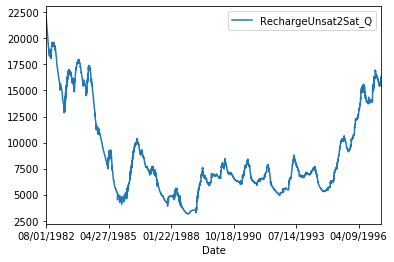

In [9]:
# To demonstrate plotting a budget component, let us plot the daily recharge values
df.plot(x='Date', y = 'RechargeUnsat2Sat_Q');

Importing the budget into Pandas allows us to access all of the powerful built in operations that come with Pandas

For example, let's plot the annual stream outflow

In [10]:
df['Date'] = pandas.to_datetime(df['Date'])
Budget_by_year = df.groupby(df.Date.dt.year).sum()

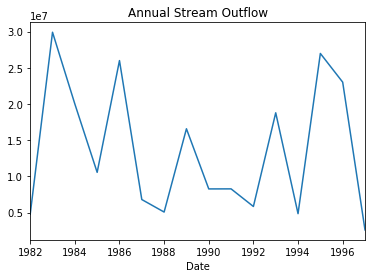

In [11]:
Budget_by_year['StreamOut_Q'].plot()
plt.title("Annual Stream Outflow");

Now let's plot the mean monthly stream outflow

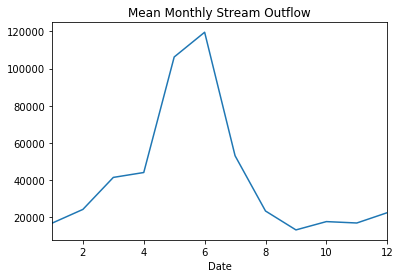

In [12]:
Budget_by_month = df.groupby(df.Date.dt.month).mean()
Budget_by_month['StreamOut_Q'].plot()
plt.title("Mean Monthly Stream Outflow");

### PRMS Statistic Variables

From the `PrmsModel` object allows users to import their statistic variables output using the `get_StatVar()` method. This method loads the statvar file and returns it to the user as a Pandas dataframe.

In [13]:
# Load the results
gsf.prms.get_StatVar()

Loading the statvar output file .....
Finished Load the statvar output file .....


,ID,Year,Month,Day,Hour,Minute,Second,basin_cfs_1,basin_gwflow_cfs_1,basin_sroff_cfs_1,basin_dunnian_1,basin_ssflow_cfs_1,basin_ppt_1,basin_snow_1,basin_pweqv_1,basin_snowcov_1,basin_actet_1,basin_potsw_1,basin_recharge_1,Date
0,1,1982,8,1,0,0,0,4.103844,-3.964766,0.139117,0.000487,0.000000,0.000000,0.000000,0.000000,0.000000,0.020947,680.605620,0.000000,1982-08-01
1,2,1982,8,2,0,0,0,3.957884,-3.952997,0.000045,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012704,649.570046,0.000000,1982-08-02
2,3,1982,8,3,0,0,0,4.078368,-3.939193,0.134918,0.000472,0.000000,0.000000,0.000000,0.000000,0.000000,0.014409,611.057569,0.000000,1982-08-03
3,4,1982,8,4,0,0,0,4.063455,-3.928081,0.131291,0.000459,0.000000,0.000000,0.000000,0.000000,0.000000,0.015524,629.305791,0.000004,1982-08-04
4,5,1982,8,5,0,0,0,4.049975,-3.917911,0.128141,0.000448,-0.000000,0.000000,0.000000,0.000000,0.000000,0.017163,671.293030,0.000027,1982-08-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5352,5353,1997,3,27,0,0,0,34.220159,-2.336412,16.826881,0.058777,14.719215,0.000000,0.000000,18.083924,0.891914,0.059704,525.456266,0.048083,1997-03-27
5353,5354,1997,3,28,0,0,0,35.477745,-2.347604,17.800707,0.062186,15.501201,0.000000,0.000000,17.805016,0.881564,0.056646,510.869867,0.050114,1997-03-28
5354,5355,1997,3,29,0,0,0,23.338710,-2.459326,8.651543,0.030212,11.556364,0.000000,0.000000,17.629650,0.871146,0.043759,518.188000,0.050969,1997-03-29
5355,5356,1997,3,30,0,0,0,30.275589,-2.427277,12.749356,0.044529,14.838732,0.012579,0.007007,17.445031,0.962941,0.034635,525.355649,0.051610,1997-03-30


Once the `StatVar()` object has been loaded the `.stat` attribute holds methods that allows the user to automatically plot all varibales. See example below:

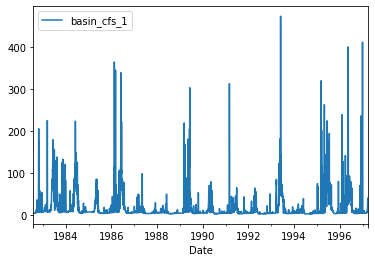

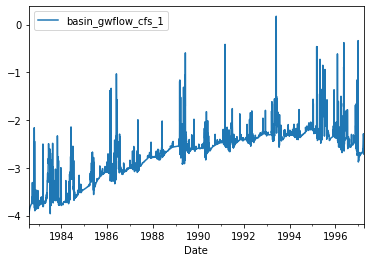

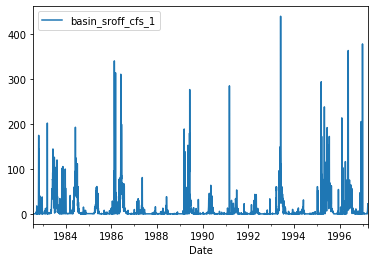

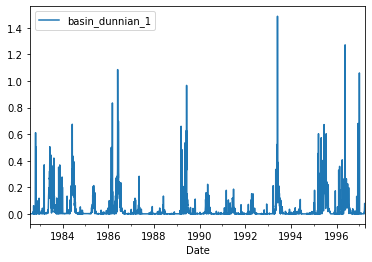

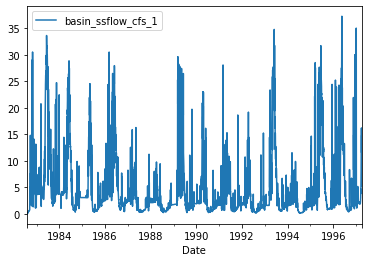

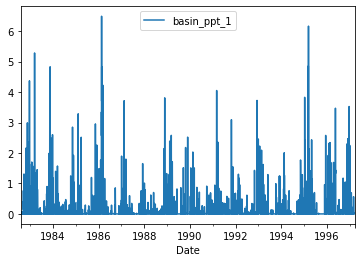

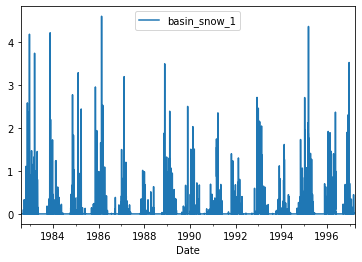

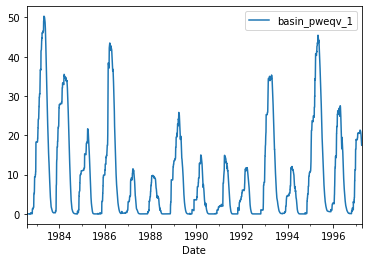

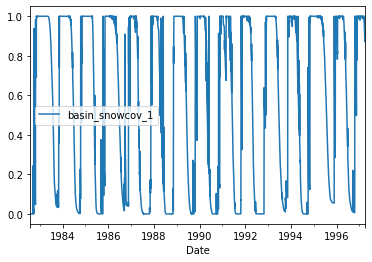

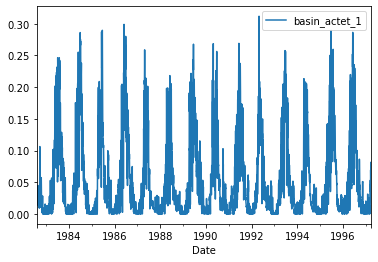

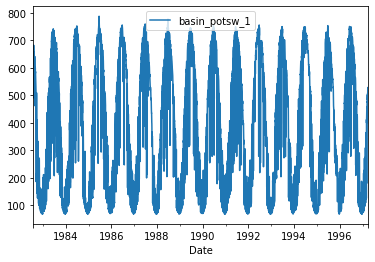

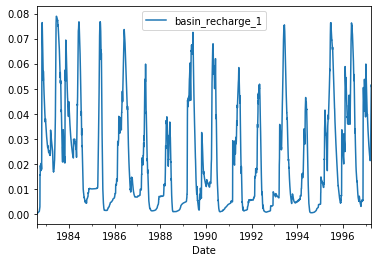

In [14]:
# To plot all results, we can use the following method...
gsf.prms.stat.plot()

# Getting results from the MODFLOW side:

MODFLOW processes are used to run the groundwater simulation of GSFLOW. As such standard MODFLOW output is also produced. The following examples give a short primer on how to load and visualize this data. For more detailed information the user is directed to [FloPy's example notebooks](https://github.com/modflowpy/flopy/tree/develop/examples/Notebooks).

In [15]:
# get our modflow model from the GsflowModel instance
mf = gsf.mf
mf

MODFLOW 2 layer(s) 77 row(s) 84 column(s) 2 stress period(s)

#### List the available output files from MODFLOW

In [16]:
# List Modflow output files
mf.output_fnames

['saghen_new.cbc',
 'saghen_new.sfr.out',
 'saghen_new.hds',
 'saghen_new.UZF.cbc']

### Modflow Head File

####  Hydraulic Head Maps

To produce hydraulic head maps the user must first load MODFLOW's binary (or formatted ASCII) head file using FloPy's utility methods. For a binary head file, the `flopy.utils.HeadFile` class is used.

In [17]:
# Load the binary head file
head_file = os.path.join(mf.model_ws, mf.output_fnames[2])
hds = flopy.utils.HeadFile(head_file)

The `get_data()` method allows the user to get an array of head values for a specific time step and stress period combination. An example is provided below

In [18]:
head = hds.get_data(kstpkper= (729, 1))

# filter by inactive cells
head[head < 0] = np.nan

Now we can create a simple filled contour plot using Matplotlib!

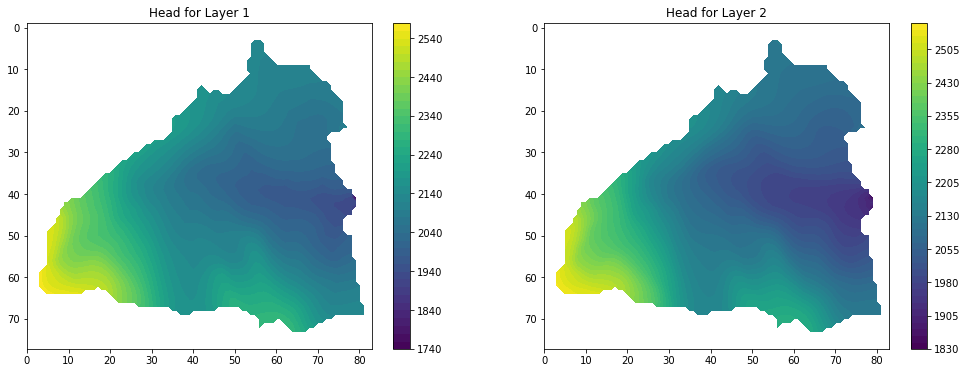

In [19]:
# Now we can plot the head map
plt.figure(figsize=(17,6));

plt.subplot(1,2,1)
plt.contourf(head[0, :, :], 50, cmap='viridis')
plt.gca().invert_yaxis()
plt.colorbar()
plt.title("Head for Layer 1")
plt.axis('equal')

plt.subplot(1,2,2)
plt.contourf(head[1, :, :], 50, cmap='viridis')
plt.gca().invert_yaxis() 
plt.colorbar()
plt.title("Head for Layer 2")
plt.axis('equal');

Now we can create a simple plot of specific discharge 

#### Plotting time series information from the Head file

The `HeadFile` object also allows the user to extract time series information with the `get_ts()` method. In this example we compare the heads in two vertically connected cells

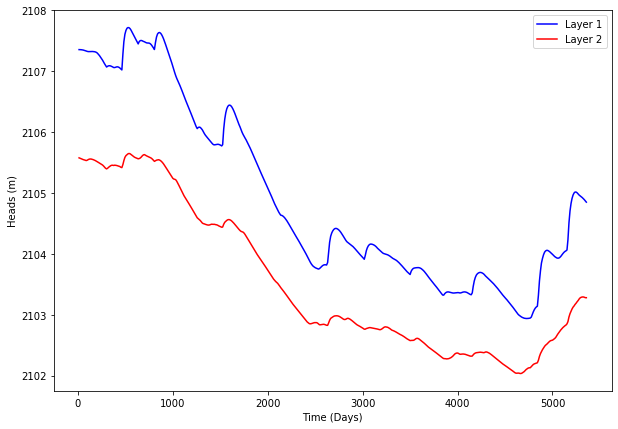

In [20]:
plt.figure(figsize=(10,7)); 

# The cell is specified as (layer, row, column)
cell = (0, 50, 50)

# Extract time series from this cell
h_ts = hds.get_ts(idx=cell)
plt.plot(h_ts[2:, 0], h_ts[2:, 1], 'b', label = "Layer 1")

# let's do the same thing for the second layer and compare the results ...
cell = (1, 50, 50)
h_ts = hds.get_ts(idx=cell)
plt.plot(h_ts[2:,0], h_ts[2:,1], 'r', label = "Layer 2")
plt.xlabel("Time (Days)")
plt.ylabel("Heads (m)")
plt.legend();

### Modflow Cell Budget 

The modflow cell budget file is a binary file that contains cell by cell stress and flow information for the model. The following examples show how to load common output and basic visualization techniques that can be used to view the data

#### Cross-sectional plot of Specific Discharge

The cell budget file contains budget information for each cell within the model. This information can be used for a number of postprocessing and visualization steps. In this example, a cross section of specific discharge vectors are produced to visualize flow direction and magnitude.

The cell budget file can be loaded using FloPy's `flopy.utils.CellBudgetFile` module. And the records it contains can be inspected using the `.textlist` attribute.

In [21]:
# Load the cell budget file and examine its record types
cbc = os.path.join(mf.model_ws, mf.output_fnames[0])
cbc = flopy.utils.CellBudgetFile(cbc)

print(cbc.textlist)

[b'   CONSTANT HEAD', b'FLOW RIGHT FACE ', b'FLOW FRONT FACE ', b'FLOW LOWER FACE ', b'  STREAM LEAKAGE', b'         STORAGE']


In [22]:
# list the time step & stress period where budget results are available
kstpkper = cbc.get_kstpkper()
print(kstpkper[0:10])

[(0, 0), (0, 1), (10, 1), (21, 1), (32, 1), (42, 1), (53, 1), (64, 1), (75, 1), (85, 1)]


Budget information can be read from the `CellBudgetFile` object using the `get_data()` method. In this example we grab the flows on three faces of each cell to produce a set of discharge vectors.

The `flopy.utils.postprocessing.get_specific_discharge()` method calculates cell centered specific discharge in three dimensions from the flow vector components.

In [23]:
fff = cbc.get_data(text="FLOW FRONT FACE", full3D=True)[-1]
frf = cbc.get_data(text="FLOW RIGHT FACE", full3D=True)[-1]
flf = cbc.get_data(text="FLOW LOWER FACE", full3D=True)[-1]

qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge((frf, fff, flf), mf)

(1800, 2500)

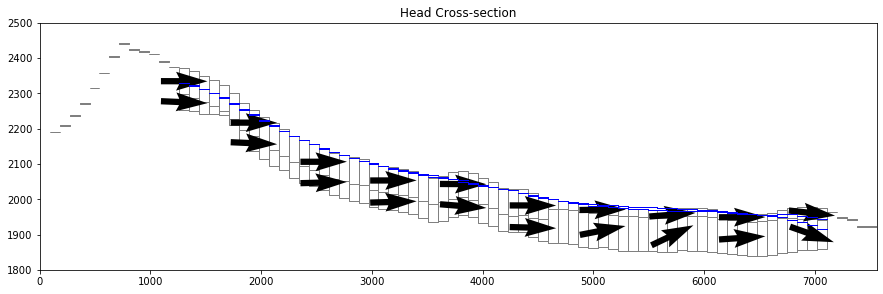

In [24]:
# get head data 
head = hds.get_data()

# create specific discharge plot
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(2, 1, 1)
ax.set_title('Head Cross-section')
pxc = flopy.plot.PlotCrossSection(model=mf, line={'row': 40}, geographic_coords=True)
patches = pxc.plot_ibound(head=head)
wt = pxc.plot_surface(head, masked_values=[999.], color='blue', lw=1)
linecollection = pxc.plot_grid()
disc = pxc.plot_vector(qx, qy, qz, normalize=True, hstep=7)
ax.set_ylim([1800, 2500])

#### Plot map view images of Cell budget file outputs

The `get_data()` method on FloPy's `CellBudgetFile` object enables the user to load and cast cell budget information into three dimensional arrays that can be plotted by Matplotlib. See example below:

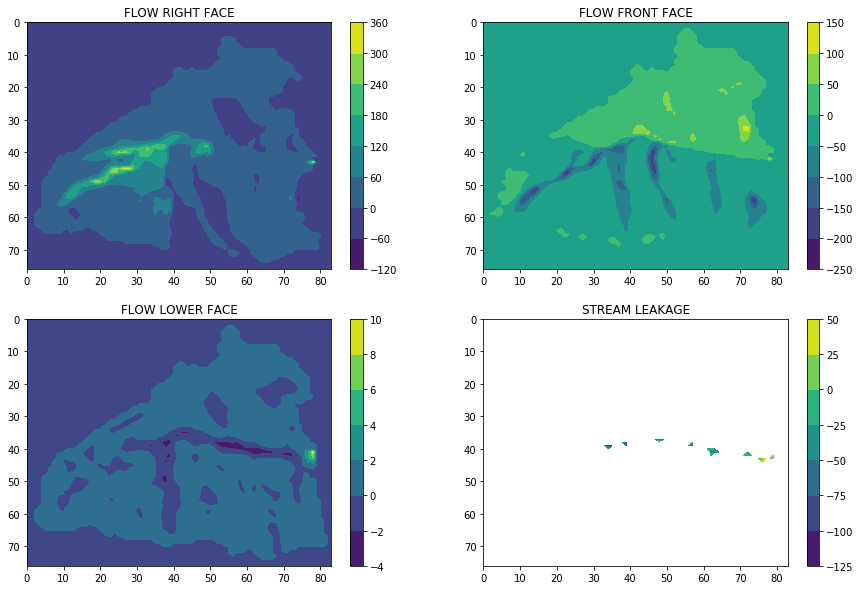

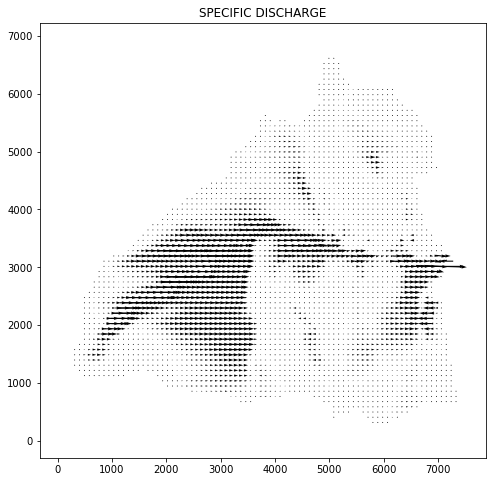

In [25]:
## Plot 
plt.figure(figsize=(15,10)); 
frf = cbc.get_data(full3D=True, kstpkper=(5355, 1), text='FLOW RIGHT FACE')[0]
plt.subplot(2,2,1)
plt.contourf(frf[0,:,:]);plt.gca().invert_yaxis(); plt.colorbar()
plt.title('FLOW RIGHT FACE')

fff = cbc.get_data(full3D=True, kstpkper=(5355, 1), text='FLOW FRONT FACE')[0]
plt.subplot(2,2,2)
plt.contourf(fff[0,:,:]);plt.gca().invert_yaxis(); plt.colorbar()
plt.title('FLOW FRONT FACE')


flf = cbc.get_data(full3D=True, kstpkper=(5355, 1), text='FLOW LOWER FACE')[0]
plt.subplot(2,2,3)
plt.contourf(flf[0,:,:]);plt.gca().invert_yaxis(); plt.colorbar()
plt.title('FLOW LOWER FACE')


xx = cbc.get_data(full3D=True, kstpkper=(5355, 1), text='STREAM LEAKAGE' )[0]
plt.subplot(2,2,4)
plt.contourf(xx[0,:,:]);plt.gca().invert_yaxis(); plt.colorbar()
plt.title('STREAM LEAKAGE')
plt.show()


fig, ax = plt.subplots(figsize=(8, 8))
mm = flopy.plot.PlotMapView(model=mf, layer=0, ax=ax)

qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge((frf, flf, fff), mf)
mm.plot_vector(qx, qy, istep=1, jstep=1)
plt.title("SPECIFIC DISCHARGE");

### Reading information from the MODFLOW list file

The modflow list file contains model budget information and convervence information that can be useful to visulize. In this example the list file is loaded using `flopy.utils.MfListBudget` and then budget information is plotted from a pandas dataframe generated by that method

In [26]:
# assemble the list file name
list_file = mf.name + ".list"

Load the list file and generate pandas dataframes using `MfListBudget`

In [27]:
mf_list = flopy.utils.MfListBudget(list_file)
incrementaldf, cumulativedf = mf_list.get_dataframes()

In [28]:
incrementaldf

,STORAGE_IN,CONSTANT_HEAD_IN,STREAM_LEAKAGE_IN,UZF_RECHARGE_IN,GW_ET_IN,SURFACE_LEAKAGE_IN,TOTAL_IN,STORAGE_OUT,CONSTANT_HEAD_OUT,STREAM_LEAKAGE_OUT,UZF_RECHARGE_OUT,GW_ET_OUT,SURFACE_LEAKAGE_OUT,TOTAL_OUT,IN-OUT,PERCENT_DISCREPANCY
1970-01-02,0.000000,136.334503,569.261230,23918.714844,0.0,0.0,24624.310547,0.000000,546.925110,9950.185547,0.0,0.0,14108.366211,24605.476562,18.834000,0.08
1970-01-03,1744.514038,136.335007,545.275696,22125.498047,0.0,0.0,24551.623047,0.031873,546.918823,10245.374023,0.0,0.0,13758.672852,24550.996094,0.627000,0.00
1970-01-13,1976.814331,136.353607,536.964417,21216.029297,0.0,0.0,23866.162109,0.007653,546.687500,9997.451172,0.0,0.0,13382.004883,23926.152344,-59.990200,-0.25
1970-01-24,2370.832275,136.417404,548.540588,20384.693359,0.0,0.0,23440.484375,0.041569,545.957703,9873.343750,0.0,0.0,13190.116211,23609.458984,-168.974594,-0.72
1970-02-04,2811.242188,136.540207,559.975708,19621.847656,0.0,0.0,23129.607422,0.486400,544.932373,9796.375000,0.0,0.0,13051.747070,23393.539062,-263.931610,-1.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1984-07-20,1628.758057,148.669693,937.729004,15950.421875,0.0,0.0,18665.578125,3661.350098,486.626709,7559.363770,0.0,0.0,6281.083984,17988.423828,677.154297,3.69
1984-07-30,1633.552979,148.735001,941.974670,15670.723633,0.0,0.0,18394.986328,3478.194336,486.456207,7526.721680,0.0,0.0,6283.313477,17774.685547,620.300781,3.43
1984-08-10,1651.851440,148.805893,949.202515,15489.699219,0.0,0.0,18239.560547,3377.431396,486.260712,7495.933594,0.0,0.0,6284.550293,17644.175781,595.384827,3.32
1984-08-21,1612.105225,148.876602,958.164673,15517.625000,0.0,0.0,18236.771484,3561.627197,486.082306,7270.604004,0.0,0.0,6363.407715,17681.720703,555.050781,3.09


Finally visualize model budget information using pandas built in plot methods

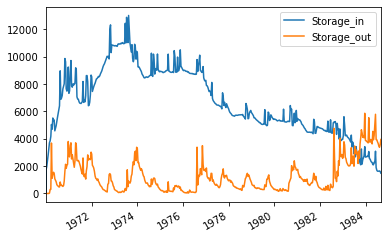

In [29]:
incrementaldf['STORAGE_IN'].plot(label='Storage_in')
incrementaldf['STORAGE_OUT'].plot(label='Storage_out')
plt.legend();

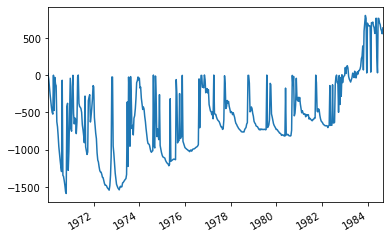

In [30]:
incrementaldf['IN-OUT'].plot();

In [31]:
# !jupyter nbconvert --to script Assemble_GSFLOW_model.ipynb